# 실습 5: Universal Function Approximator 학습시키기

Universal Approximation Theorem에 의거하여 보편적인 함수 $f$의 근사함수 $F$의 모델을 $ F(\{v_i\}, \{\textbf{w}_i\}, \{b_i\}; \textbf{x}) = \sum_{i=1}^{N} v_{i}\varphi(\textbf{x} \cdot \textbf{w}_{i} + b_{i})$ 로 세우고 학습을 진행해볼 것이다.

학습용 데이터셋을 $\textbf{x}$와 $\textbf{x}$에 대응되는 truth 데이터 $f(\textbf{x})$의 데이터 쌍들로 구성한 후, 경사하강법을 이용하여 적절한 모델 파라미터 $\{v_i\}, \{w_i\}, \{b_i\}$ 를 구함으로써 보편적인 수학적 함수 $f$의 근사함수를 학습시킬 수 있다.

### 목표

이번 실습에서는 일변수 함수인 $f(x)=cos(x), x \in [-2\pi, 2\pi]$의 근사함수를 구해볼 것이다. 여기서 $f$가 일변수 스칼라 함수이기 때문에 $x$, $w_i$를 벡터가 아닌 스칼라로 생각할 수 있다. 그러나 추후에 고차원 벡터(길이가 긴 1차원 배열)를 입력받는 모델에 대해서도 확장하기 위해, 프로그래밍할 때 스칼라가 아닌 벡터(즉, 길이가 1인 1차원 배열)라고 생각하고 프로그래밍 해보자.

주의) 여기서 세 종류의 모델 파라미터 각각의 개수이자 뉴런의 개수인 $N$은 하이퍼파라미터에 속한다. 즉, 학습을 통해 컴퓨터가 직접 적절한 값을 찾아가는 것이 아니라, 인간이 직접 시행착오를 통해 적절히 찾아 지정해주어야 한다.

그동안의 실습에서 꾸준히 사용해온 대표적인 라이브러리들을 미리 import 한 후 본격적인 실습을 시작해보자.

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

### Step1. 모델(클래스) 정의하기 : 순전파

우리가 가장 먼저 할 일은 Universal Approximation Theorem에 따라 구하게 될 근사함수 $F(x)$의 형태를 모델(클래스)로 정의해주는 것이다. 선형모델에 비해 구현하기 까다롭지만, torch와 NumPy 라이브러리의 벡터화된 연산을 이용하면 짧고 간단한 코드를 작성할 수 있다.

#### batch의 개념 짚고 넘어가기

우리는 입력 데이터를 $M$개씩 묶어 batch $\{x_{j}\}_{j=1}^{M}$로 구성한 후, batch를 이루는 개별적인 데이터에 대해 독립적으로 순전파를 진행할 것이다. 즉, $M$개의 데이터를 모델에 한 번에 전달하여 대응되는 $M$개의 예측을 한 번에 산출할 것이다.

batch 내 개별 데이터에 대한 함숫값 $ F(\{v_i\}, \{{w}_i\}, \{b_i\}; x_j)$를 구할 때 사용되는 연산은 batch 내의 다른 데이터들에는 영향을 받지 않는 독립적인 연산임을 꼭 명심하자. 각 예측은 대응되는 입력 데이터에 대해서만 이루어지기 때문에 다음의 값들에만 의존한다.

- 모델 파라미터: $\{v_i\}, \{w_i\}, \{b_i\}$
- 데이터 $x_j$


하나의 batch 당 $M$개의 독립적인 예측을 진행해야 한다고 하면 흔히 for문 등의 반복문을 떠올릴 것이다. 그러나 batch를 이루는 입력 데이터 $M$개를 shape-$(M, 1)$인 NumPy 배열로 정의하면 NumPy의 벡터화된 연산을 사용하여 순전파를 한 번에 진행할 수 있다.

#### 근사함수 수식을 코딩으로 구현하기

이제 근사함수 $ F(\{v_i\}, \{{w}_i\}, \{b_i\}; x) = \sum_{i=1}^{N} v_{i}\varphi(x \cdot {w}_{i} + b_{i})$ 의 식을 batch size가 $M$인 batch에 대해 어떻게 코딩할지 고민해보자.

먼저, $x \cdot w_{i}$는 torch 라이브러리의 matmul을 이용하여 계산할 수 있다. 이 문제에서 $x$와 $w_i$는 1차원 벡터이다. 따라서 $x \cdot w_i$는 벡터 간의 내적을 뜻하지만, 동시에 행벡터와 열벡터의 행렬곱으로도 생각할 수 있기 때문에 matmul 연산을 사용할 수 있다.

행렬곱을 이용하여 $N$개의 $w_i$에 대해 $x \cdot w_{i}$를 한번에 계산해보자. 1차원 행벡터 $x$를 1차원 열벡터 $w_i$ $N$개를 열에 대해 늘어놓은 행렬 $W$와 행렬곱하면 다음과 같다.


$$\begin{equation}
\begin{pmatrix}x\end{pmatrix}
\begin{pmatrix}w_{1} & w_{2} & \cdots & w_N \end{pmatrix} =
\begin{pmatrix}x \cdot w_{1} & x \cdot w_{2} & \cdots & x \cdot w_N \end{pmatrix}
\end{equation}$$

결과적으로, $N$개의 $x \cdot w_{i}$ 값이 담긴 shape-$(1, N)$인 행렬을 얻게 된다.

만약 입력데이터가 2차원 벡터라면 아래와 같은 연산을 거쳐야 한다.
$$\begin{equation}
\begin{pmatrix}x_1^{1} & x_1^{2}\end{pmatrix}
\begin{pmatrix}w_{1}^{1} & w_{2}^{1} & \cdots & w_N^{1} \\
w_1^{2} & w_2^{2} & \cdots & w_N^{2}\end{pmatrix} =
\begin{pmatrix}x_1^{1} \cdot w_{1}^{1} + x_1^{2} \cdot w_1^{2} , & x_1^{1} \cdot w_2^{1} + x_1^{2} \cdot w_{2}^{2} ,  & \cdots & x_1^{1} \cdot w_N^{1} +  \cdot x_1^{2} \cdot w_N^{2}
\end{pmatrix}
\end{equation}$$

이제 batch를 이루는 $M$개의 입력 데이터 $x_j$에 대해 위의 행렬곱을 한 번에 계산해보자. 1차원 행벡터 $x_j$를 행에 대해 늘어놓은 행렬 $X$를 1차원 열벡터 $w_i$ N개를 열에 대해 늘어놓은 행렬 $W$와 행렬곱하면 다음과 같다.

$$
\begin{equation}
\begin{pmatrix}x_1\\
x_2\\
\vdots\\
x_M
\end{pmatrix}
\begin{pmatrix}w_{1} & w_{2} & \cdots & w_N \end{pmatrix} =
\begin{pmatrix}x_1 \cdot w_{1} & x_1 \cdot w_{2} & \cdots & x_1 \cdot w_N \\
x_2 \cdot w_{1} & x_2 \cdot w_{2} & \cdots & x_2 \cdot w_N \\
\vdots & \vdots & \ddots & \vdots \\
x_M \cdot w_{1} & x_M \cdot w_{2} & \cdots & x_M \cdot w_N
\end{pmatrix}
\end{equation}
$$

결과적으로, $MN$개의 $x_{j} \cdot w_{i}$ 값이 담긴 shape-$(M, N)$인 행렬을 얻게 된다.

마찬가지로, 입력데이터가 2차원 벡터이고 batch M를 적용한다면 다음과 같은 shape-$(M, N)$인 행렬을 얻게 된다.

$$
\begin{equation}
\begin{pmatrix}x_1^{1} & x_1^{2}\\
x_2^{1} & x_2^{2}\\
\vdots\\
x_M^{1} & x_M^{2}
\end{pmatrix}
\begin{pmatrix}w_{1}^{1} & w_{2}^{1} & \cdots & w_N^{1} \\
w_1^{2} & w_2^{2} & \cdots & w_N^{2}\end{pmatrix} =
\begin{pmatrix}x_1^{1} \cdot w_{1}^{1} + x_1^{2} \cdot w_1^{2} & x_1^{1} \cdot w_{2}^{1} + x_1^{2} \cdot w_2^{2} & \cdots & x_1^{1} \cdot w_{N}^{1} + x_1^{2} \cdot w_N^{2} \\
x_2^{1} \cdot w_{1}^{1} + x_2^{2} \cdot w_1^{2} & x_2^{1} \cdot w_{2}^{1} + x_2^{2} \cdot w_2^{2} & \cdots & x_2^{1} \cdot w_{N}^{1} + x_2^{2} \cdot w_N^{2} \\
\vdots & \vdots & \ddots & \vdots \\
x_M^{1} \cdot w_{1}^{1} + x_M^{2} \cdot w_1^{2} & x_M^{1} \cdot w_{2}^{1} + x_M^{2} \cdot w_2^{2} & \cdots & x_M^{1} \cdot w_{N}^{1} + x_M^{2} \cdot w_N^{2}
\end{pmatrix}
\end{equation}
$$

결국, $X$에 shape-$(M,1)$, $W$에 shape-$(1,N)$의 적절한 모양의 배열만 넣어주면 한 번의 행렬곱(torch.matmul) 계산으로 원하는 결과를 얻을 수 있음을 알 수 있다. 따라서 $F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) = \sum_{i=1}^{N} v_{i}\varphi(x_{j} \cdot w_{i} + b_{i})$ 에서 $x_{j} \cdot w_{i}$ 부분을 구하는 코드는 다음과 같다.

```python
torch.matmul(x, w)
```

그 다음으로는 브로드캐스팅 성질을 이용한다. 우리는 스칼라 $b_i$가 shape-$(M, N)$인 행렬의 i번째 열 전체에 각각 더해지길 바란다.

\begin{pmatrix}x_1 \cdot w_{1}+b_1 & x_1 \cdot w_{2}+b_2 & \cdots & x_1 \cdot w_N+b_N \\
x_2 \cdot w_{1}+b_1 & x_2 \cdot w_{2}+b_2 & \cdots & x_2 \cdot w_N+b_N \\
\vdots & \vdots & \ddots & \vdots \\
x_M \cdot w_{1}+b_1 & x_M \cdot w_{2}+b_2 & \cdots & x_M \cdot w_N+b_N
\end{pmatrix}

$\{b_i\}$를 shape-$(1,N)$인 행렬로 정의해주면, NumPy와 torch의 브로드캐스팅 성질에 의해 다음의 코드 한 줄로 해결이 된다. 즉, $x_{j} \cdot w_{i} + b_{i}$ 부분을 구하는 코드는 다음과 같다.

```python
torch.matmul(x, w)+b
```

그 다음, 우리는 행렬의 각 원소에 대한 시그모이드 함숫값을 구해야 한다.

\begin{pmatrix}\varphi(x_1 \cdot w_{1}+b_1) & \varphi(x_1 \cdot w_{2}+b_2) & \cdots & \varphi(x_1 \cdot w_N+b_N) \\
\varphi(x_2 \cdot w_{1}+b_1) & \varphi(x_2 \cdot w_{2}+b_2) & \cdots & \varphi(x_2 \cdot w_N+b_N) \\
\vdots & \vdots & \ddots & \vdots \\
\varphi(x_M \cdot w_{1}+b_1) & \varphi(x_M \cdot w_{2}+b_2) & \cdots & \varphi(x_M \cdot w_N+b_N)
\end{pmatrix}

NumPy와 torch에서 수학 연산을 하는 함수에 NumPy 배열 혹은 torch 텐서를 넣어주면 행렬의 모든 원소에 수학 연산을 각각 적용한 행렬을 얻을 수 있다. sigmoid 함수는 앞서 살펴본대로 torch에서 import 할 수 있다. 따라서 $\varphi(x_{j} \cdot w_{i} + b_{i})$ 부분을 구하는 코드는 다음과 같다.

```python
torch.sigmoid(torch.matmul(x, w) + b)
```

마지막으로 우리는 위에서 구한 행렬의 각 행 별로 $i$번째 원소에 $v_i$를 곱한 후 $(i=1,2, \cdots, N)$에 대해 다 더해주어야 한다. 그래서 최종적으로 다음과 같은 shape-$(M,1)$인 행렬을 구하기를 바란다.

\begin{equation}
\begin{pmatrix}\sum_{i=1}^{N} v_{i}\varphi(x_{1} \cdot w_{i} + b_{i}) \\
\sum_{i=1}^{N} v_{i}\varphi(x_{2} \cdot w_{i} + b_{i}) \\
\vdots \\
\sum_{i=1}^{N} v_{i}\varphi(x_{M} \cdot w_{i} + b_{i})
\end{pmatrix}
\end{equation}

이 행렬을 행렬곱 형태로 나타내면 다음과 같다. $\{v_i\}$는 shape-$(N,1)$인 배열로 정의해주어야 함을 확인할 수 있다.

\begin{equation}
\begin{pmatrix}\varphi(x_1 \cdot w_{1}+b_1) & \varphi(x_1 \cdot w_{2}+b_2) & \cdots & \varphi(x_1 \cdot w_N+b_N) \\
\varphi(x_2 \cdot w_{1}+b_1) & \varphi(x_2 \cdot w_{2}+b_2) & \cdots & \varphi(x_2 \cdot w_N+b_N) \\
\vdots & \vdots & \ddots & \vdots \\
\varphi(x_M \cdot w_{1}+b_1) & \varphi(x_M \cdot w_{2}+b_2) & \cdots & \varphi(x_M \cdot w_N+b_N)
\end{pmatrix}
\begin{pmatrix}v_1\\
v_2\\
\vdots\\
v_N
\end{pmatrix}=
\begin{pmatrix}\sum_{i=1}^{N} v_{i}\varphi(x_{1} \cdot w_{i} + b_{i}) \\
\sum_{i=1}^{N} v_{i}\varphi(x_{2} \cdot w_{i} + b_{i}) \\
\vdots \\
\sum_{i=1}^{N} v_{i}\varphi(x_{M} \cdot w_{i} + b_{i})
\end{pmatrix}
\end{equation}

이로써 batch size가 $M$인 입력데이터 $\{x_{j}\}_{j=1}^{M}$에 대해 $F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) = \sum_{i=1}^{N} v_{i}\varphi(x_{j} \cdot w_{i} + b_{i})$을 한 번에 계산하는 벡터화 연산 코드를 찾아낼 수 있었다.

```python
out1 = torch.sigmoid(torch.matmul(x, w) + b)  # shape-(M,N)
model_out = torch.matmul(out1, v)             # shape-(M,1)
```

model_out이 shape-$(M, 1)$인 텐서이므로, batch size가 $M$인 경우 대응되는 예측값이 총 $M$개의 독립적인 값으로 나타난다는 것을 확인할 수 있다.

#### 모델(클래스) 정의하기

이제, 아래의 Model 클래스를 완성해보자. 모델 파라미터 $\{w_i\}$, $\{b_i\}$, $\{v_i\}$가 어떤 형태이고 왜 그런 형태여야 하는지 이해한 것을 바탕으로 initialize_params() 메서드를 작성할 수 있을 것이다. 그리고 model_out의 식을 어떻게 프로그래밍하는지 이해했다면, \_\_call\_\_() 메서드를 작성할 수 있을 것이다. 주석을 보며 스스로 작성해보자.
(load_parameters 메서드는 학습 과정에 필요한 메서드는 아니고, Step 5에서 학습 과정을 시각적으로 확인하는 데 사용하기 위해 정의해둔 메서드이다.)

In [2]:
class Model(torch.nn.Module):
    def initialize_params(self, N: int):
        self.w = torch.nn.Parameter(torch.randn(1, N))
        self.b = torch.nn.Parameter(torch.randn(1, N))
        self.v = torch.nn.Parameter(torch.randn(N, 1))

    def __init__(self, num_neurons: int):
        super(Model, self).__init__()
        self.initialize_params(num_neurons)

    def forward(self, x):
        out1 = torch.sigmoid(torch.matmul(x, self.w) + self.b)   # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
        return torch.matmul(out1, self.v)  # matmul[(M, N) w/ (N, 1)] --> (M, 1)

    @property
    def model_parameters(self):
        return (self.w, self.b, self.v)

    def load_parameters(self, w, b, v):
        self.w = torch.nn.Parameter(w)
        self.b = torch.nn.Parameter(b)
        self.v = torch.nn.Parameter(v)

### Step2. 손실함수 작성하기

모델을 정의했으므로 우리는 순전파를 통해 초기 근사함수 $F(x)$의 값을 얻을 수 있다. 초기 근사함수 $F(x)$는 임의로 지정한 모델 파라미터에 의해 정의된 함수이므로, 당연히 $f(x)=cos(x)$와는 차이가 클 것이다. 그러나 우리는 Universal Approximation Theorem에 의해, 근사함수 $F(\textbf x)$가 임의의 $\varepsilon > 0$에 대해 $ | F( \textbf{x} ) - f ( \textbf{x} ) | < \varepsilon $를 만족하도록 만드는 모델 파라미터 값들이 반드시 존재한다는 것을 알고 있다. 따라서, 손실함수를 $\mathscr{L}(x) = | F(x) - f(x) | = | F( \{v_i\}, \{w_i\}, \{b_i\}; x ) - \cos ( x ) |$ 로 정의하여, 손실함수 값이 0에 가까워지도록 학습하는 것이 자연스럽다.

그런데 우리는 batch size가 $M$인 batch를 모델에 한 번에 입력해줄 것이므로, $M$개의 손실함수 값 $\mathscr{L}(x_j)= | F( \{v_i\}, \{w_i\}, \{b_i\}; x_j ) - \cos ( x_j ) | \quad(j = 1, \dots, M)$을 한 번에 얻게된다. 우리는 이렇게 얻은 $M$개의 손실에 대해 평균을 구하여, 평균적인 손실을 학습에 사용할 것이다. batch 전체의 평균적인 손실을 학습에 사용하면 모델의 가중치를 더 연속적이고 부드럽게 이동시킬 수 있다.

$L(\{v_i\}, \{w_i\}, \{b_i\}; \{x_k\} ) = \frac{1}{M}\sum_{j=1}^{M} | F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) - \cos ( x_{j} ) |$

다음 코드의 주석을 잘 보고, 손실함수를 작성해보자. torch의 수학 연산 함수들을 이용하여 단 한 줄의 코드로 완성해보자.

In [3]:
def loss_func(pred, true):
    """
    모델이 예측한 값과 실제 값 사이의 MSE 값을 계산하는 함수

    매개변수 (Parameters)
    ----------
    y_pred : Tensor, N개의 원소로 구성(shape-(N,))
        N개의 예측값으로 구성된 텐서

    y_true : array_like, N개의 원소로 구성(shape-(N,))
        N개의 실제 값으로 구성딘 배열

    반환 값 (Returns)
    -------
    mse : Tensor, 단일 원소(shape-())
        MES 값을 원소로 갖는인 스칼라 텐서

    실행 예시
    --------
    >>> pred = torch.tensor([1, 2, 3], dtype=torch.float32)
    >>> true = torch.tensor([1, 1, 3], dtype=torch.float32)
    >>> mean_squared_error(pred, true)
    Tensor(0.33333333)
    """
    # 여기에 코드 작성
    mse = torch.mean((pred - true)**2)
    return mse

### Step3. 경사하강법 함수 작성하기 : 역전파

모델 파라미터에 해당하는 텐서들과 학습률을 매개변수로 받아 경사하강법을 진행하는 함수를 작성해보자.

In [4]:
def gradient_step(tensors, learning_rate):
    if isinstance(tensors, torch.Tensor):
        # Only one tensor was provided. Pack
        # it into a list so it can be accessed via
        # iteration
        tensors = [tensors]

    for t in tensors:
      if t.grad is not None:
        t.data -= learning_rate * t.grad
        # t.grad.zero_()

### Step4. 학습시키기 : 순전파와 역전파의 반복

#### 데이터 준비하기

함수 $f(x)$의 근사함수를 구하는 상황이므로 데이터셋을 준비하는 것이 무척 간단하다. 학습용 데이터셋은 $(x_n, y_n^{(true)})$ 쌍으로 구성하면 되는데, 이 문제 상황에서는 $y_n^{(true)} = cos(x_n)$이다. 예를 들어 구간 $[-2\pi, 2\pi]$에서 근사함수를 구하고 싶다면, 구간 $[-2\pi, 2\pi]$를 균등하게 1000개 정도의 구간으로 나눈 배열을 입력되는 $x$데이터(train_data)로 사용하고, $cos$ 연산을 적용하는 함수를 true_f로 정의한 후, truth_data 배열을 true_f에 통과하여 얻어진 배열을 truth 데이터로 사용하면 될 것이다.

이때, 학습용 데이터를 이루는 $x_n$ 값들은 NumPy 배열이나 torch의 상수 텐서로 정의하여 .backward() 메서드의 수행과정에서 불필요한 편미분계수가 계산되지 않도록 해야 한다.

#### 학습시키기

학습시키기에 앞서 train_data와 truth를 잘 정의해주어야 한다. 또한, Step 1에서 정의한 Model 클래스의 객체 model을 생성하여 모델 파라미터들이 초기화되도록 해야 한다.

주석을 잘 보고 데이터와 모델을 준비해보자.

In [5]:
# shape-(1000,1)인 학습용 데이터셋 {x_n} 정의하기
# NumPy 배열이나 torch의 상수 텐서로 정의해야 함
# 배열의 이름은 train_data로 지정하기

train_data = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(1000, 1)


# true_f(x) 정의하기
# x를 입력받아 np.cos(x)를 반환하는 함수로 정의하면 됨
# y의 truth를 true_f(train_data) 와 같이 구할 수 있도록

def true_f(x):
  return np.cos(x)


# 위에서 작성한 Model 클래스 이용하여 model 객체 생성하기
# 하이퍼파라미터인 뉴런 개수 num_neurons=10 으로 시작
neurons = 10
model = Model(neurons)


학습시키기 전, 초기화된 상태의 model은 우리가 근사하고자 하는 목표 함수인 $f(x) = cos(x)$와 크게 다르다. 함수 $f$와 학습시키기 전의 근사함수 모델 $F$가 어떻게 다른지 살펴보자.

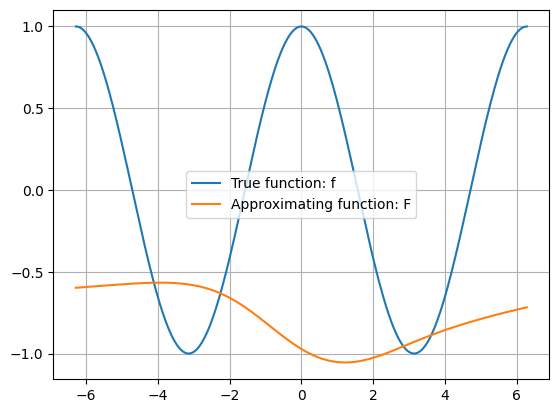

In [6]:
# "True function: f" 와 근사함수인 "Approximating function: F"를 같은 축 상에 그래프로 나타내기
# 위에서 정의한 true_f 함수와 초기화된 model 객체를 잘 활용하기
# 두 그래프가 각각 어떤 그래프인지 알아보기 위해 label 설정은 필수, 색상 설정은 자유롭게

# Convert train_data to torch tensor
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)

# Create the plot
fig, ax = plt.subplots()
ax.plot(train_data, true_f(train_data), label="True function: f")
ax.plot(train_data, model(train_data_tensor).detach().numpy(), label="Approximating function: F")
ax.grid()
ax.legend()

plt.show()

이제 본격적으로 학습을 진행할 것이다. 하이퍼파라미터인 batch size, 학습률, epoch 수 등을 지정해준 상태에서 학습을 시작한다. 매 epoch마다 랜덤 batch 별 학습을 진행하기 위해서 batch를 먼저 정해주고, 각 batch에 대해 한 번에 학습을 진행하는 방식으로 프로그래밍하면 된다.

In [7]:
# Training loop
batch_size = 25
learning_rate = 0.01
loss_values = []

for epoch_cnt in range(1000):
    # 한 번의 epoch가 반복될 때마다 시행하는 코드

    # 학습용 데이터셋을 무작위로 재배열하기
    # `idxs`를 무작위로 재배열하여 데이터셋의 인덱스를 어떻게 재배열할지 결정
    idxs = np.arange(len(train_data)) # -> array([0, 1, ..., 999])
    np.random.shuffle(idxs)

    for batch_cnt in range(0, len(train_data) // batch_size):
        # (총 학습용 데이터셋 개수)를 (batch 크기)로 나눈 몫만큼 반복하며 시행

        # 학습용 데이터셋의 새로운 인덱스를 슬라이싱하여 그 배열을 batch_indices에 저장
        # 어느 범위까지 잘라야 할지 생각해보기
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]

        # 학습에 사용할 batch를 추출하기 위해, 윗 단계에서 저장한 batch_indices 위치의 데이터들을 모아 batch와 truth를 생성
        batch = train_data[batch_indices]
        truth = true_f(batch)

        # numpy 배열을 torch 텐서로 변환
        batch_tensor = torch.tensor(batch, dtype=torch.float32)
        truth_tensor = torch.tensor(truth, dtype=torch.float32)

        # 은닉층부터 출력층의 가중치 곱까지의 순전파에서 전달되는 값 구하기
        prediction = model(batch_tensor)

        # torch의 자동미분 함수를 활용하여 역전파 진행
        loss = loss_func(prediction, truth_tensor)

        # 기울기 초기화
        model.zero_grad()

        # torch의 자동미분 함수를 활용하여 역전파 진행
        loss.backward()

        # grad_descent 함수를 이용하여 경사하강의 한 스텝 진행
        gradient_step(model.parameters(), learning_rate)


    loss_values.append(loss.detach().clone().numpy())
    print(f"Epoch {epoch_cnt+1}----------------------------")
    print(f"loss: {loss:.6f}")

Epoch 1----------------------------
loss: 0.757845
Epoch 2----------------------------
loss: 0.528481
Epoch 3----------------------------
loss: 0.554467
Epoch 4----------------------------
loss: 0.571712
Epoch 5----------------------------
loss: 0.444963
Epoch 6----------------------------
loss: 0.653318
Epoch 7----------------------------
loss: 0.542488
Epoch 8----------------------------
loss: 0.478481
Epoch 9----------------------------
loss: 0.437228
Epoch 10----------------------------
loss: 0.502718
Epoch 11----------------------------
loss: 0.528048
Epoch 12----------------------------
loss: 0.372743
Epoch 13----------------------------
loss: 0.332625
Epoch 14----------------------------
loss: 0.281452
Epoch 15----------------------------
loss: 0.443015
Epoch 16----------------------------
loss: 0.457144
Epoch 17----------------------------
loss: 0.491902
Epoch 18----------------------------
loss: 0.415463
Epoch 19----------------------------
loss: 0.438751
Epoch 20-------------

# 참고


TensorDataset과 Dataloader 기능을 쓰면 더 쉽게 batch를 나누고 섞을 수 있다.

In [8]:
model = Model(neurons)

In [9]:
from torch.utils.data import DataLoader, TensorDataset
# Prepare the dataset
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
truth_tensor = torch.tensor(true_f(train_data), dtype=torch.float32)
dataset = TensorDataset(train_data_tensor, truth_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
learning_rate = 0.01

for epoch_cnt in range(1000):
    for batch in dataloader:
        batch_tensor, truth_tensor = batch






        # 은닉층부터 출력층의 가중치 곱까지의 순전파에서 전달되는 값 구하기
        prediction = model(batch_tensor)

        # torch의 자동미분 함수를 활용하여 역전파 진행
        loss = loss_func(prediction, truth_tensor)

        # 기울기 초기화
        model.zero_grad()

        # torch의 자동미분 함수를 활용하여 역전파 진행
        loss.backward()

        # grad_descent 함수를 이용하여 경사하강의 한 스텝 진행
        gradient_step(model.parameters(), learning_rate)

    loss_values.append(loss.detach().clone().numpy())
    print(f"Epoch {epoch_cnt + 1}----------------------------")
    print(f"loss: {loss:.6f}")

Epoch 1----------------------------
loss: 0.569081
Epoch 2----------------------------
loss: 0.314240
Epoch 3----------------------------
loss: 0.499233
Epoch 4----------------------------
loss: 0.493502
Epoch 5----------------------------
loss: 0.383801
Epoch 6----------------------------
loss: 0.333416
Epoch 7----------------------------
loss: 0.405182
Epoch 8----------------------------
loss: 0.395662
Epoch 9----------------------------
loss: 0.345236
Epoch 10----------------------------
loss: 0.616420
Epoch 11----------------------------
loss: 0.304153
Epoch 12----------------------------
loss: 0.406900
Epoch 13----------------------------
loss: 0.347292
Epoch 14----------------------------
loss: 0.378023
Epoch 15----------------------------
loss: 0.410080
Epoch 16----------------------------
loss: 0.422218
Epoch 17----------------------------
loss: 0.444821
Epoch 18----------------------------
loss: 0.377985
Epoch 19----------------------------
loss: 0.383918
Epoch 20-------------

# -

학습시킨 후의 model은 $f(x) = cos(x)$와 꽤 비슷해진다. 아래 코드를 완성하여 학습시킨 후의 근사함수 모델 $F$가 함수 $f$와 얼마나 가까워졌는지 살펴보자.

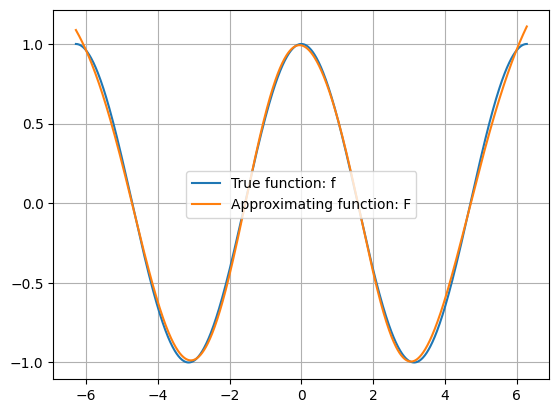

In [10]:
# Plotting
fig, ax = plt.subplots()
x = train_data
ax.plot(train_data, true_f(train_data), label="True function: f")

# Convert train_data to torch tensor for model prediction
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
model_output = model(train_data_tensor).detach().numpy()

ax.plot(train_data, model_output, label="Approximating function: F")
ax.grid()
ax.legend()

plt.show()

### Step5. 학습 과정 관찰하기

위에서 학습시킨 model의 loss가 어떻게 변하는지 관찰한다.

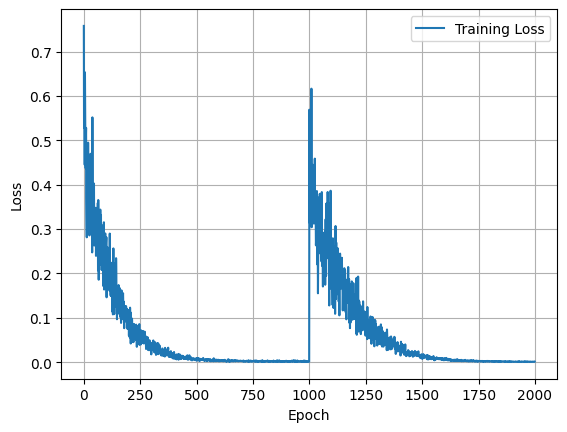

In [11]:
# Plotting loss values
plt.figure()
plt.plot(loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#### 각 뉴런 별 학습 결과 그래프로 나타내기

이번에는 학습을 진행한 $N=10$개의 뉴런으로부터 얻는 각각의 결과값을 그래프로 나타내어 보자. 즉, $i=1, ..., N$의 N개의 뉴런에 대해 구간 $x \in [-2\pi, 2\pi]$에서 $\varphi(x \cdot w_{i} + b_{i})$의 그래프가 어떻게 나타나는지 그래프로 그려보면 된다. 각 뉴런의 결과까지만 확인하는 것이므로 이 식에서 $v_i$는 미포함한다.

$N=10$개의 뉴런으로부터 얻는 결과값을 하나의 그래프로 나타내기 위해, subplot이 열 ncols=2, 행 nrows=model.N//2 개인 그래프를 생성할 것이다. 따라서, axes는 원소가 2*(N//2)개인 배열이 된다. 또한 model.parameters[0] (배열 $\{w_i\}$)와 model.parameters[1] (배열 $\{b_i\}$)은 원소가 $N$개인 배열이다. $N$개의 뉴런에 대응되는 각각의 축에 대해, 정의역 x와 각각의 모델 파라미터들로부터 얻어지는 (x, sigmoid(x * w_i + b_i))를 plot하면 우리가 원하는 결과를 얻을 수 있다.

다음의 코드를 완성하여 원하는 $N=10$개의 그래프를 그려보자.

참고로, 코드에 나온 flatten() 함수는 다차원 배열을 1차원으로 풀어쓰는 역할을 해주는 함수로, 이론에서 잠깐 나왔던 벡터화(Vectorization)를 수행하는 함수이다. 또한 zip() 함수는 Python의 내장함수로, 여러 개의 iterable한 객체들이 전달되었을 때 각 객체의 요소들을 순서대로 하나씩 뽑아 튜플의 형태로 묶어주는 역할을 한다. 특히 for문에서 활용하기 유용한 함수이다. flatten()과 zip() 함수를 꼭 이용해야만 구현할 수 있는 것은 아니지만, 알고 있으면 더 쉽게 프로그래밍하는 데 도움이 될 것이다.

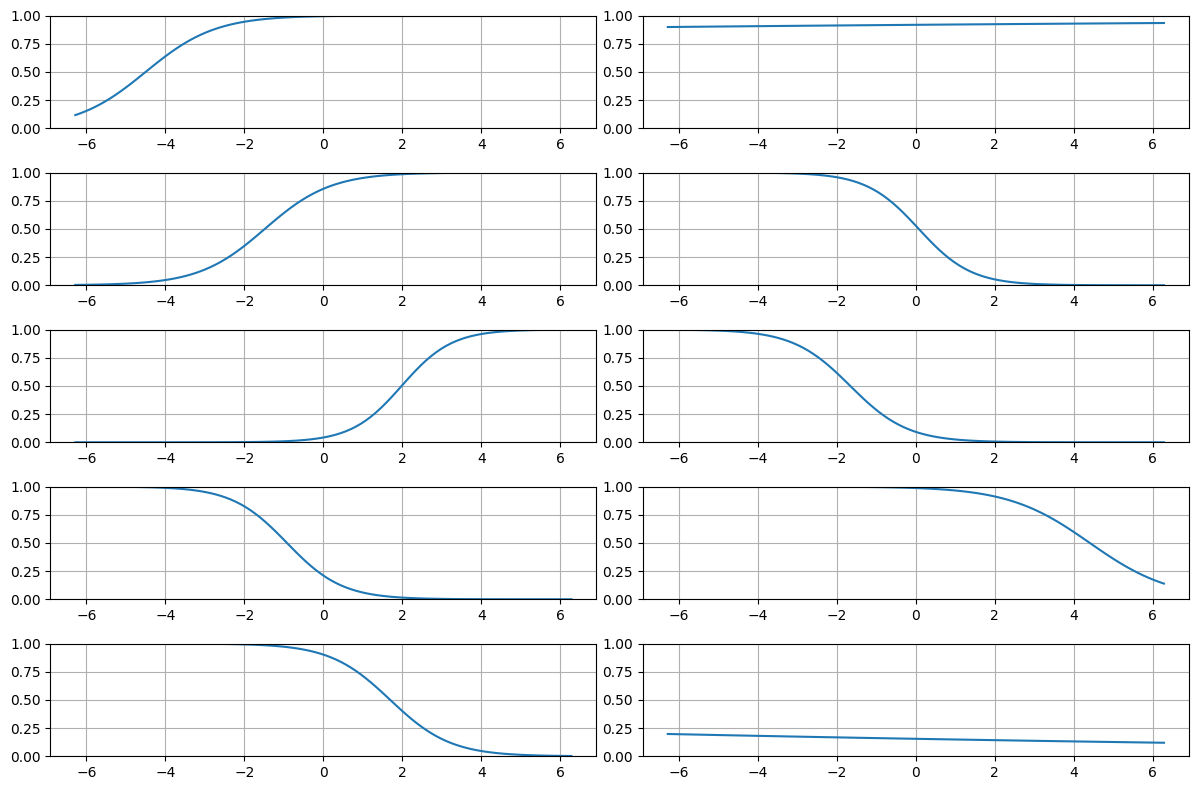

In [12]:
# Plotting weights and biases
fig, axes = plt.subplots(ncols=2, nrows=neurons // 2, figsize=(12, 8))
x = np.linspace(-2 * np.pi, 2 * np.pi, 100) # x축 값 설정

# 파라미터 접근
w, b, _ = model.model_parameters

for ax, w_i, b_i in zip(axes.flatten(), w.flatten(), b.flatten()):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y = torch.sigmoid(x_tensor * w_i.item() + b_i.item())
    ax.plot(x, y.detach().numpy())
    ax.grid(True)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

마지막으로 각 뉴런에서 얻어진 결과값에 $v_i$를 곱해준 값들을 하나의 그래프에 plot 하고, 이들을 모두 합한 것을 굵은 검은 점선으로 plot 해보자.  즉, $i=1, ..., N$의 N개의 뉴런에 대해 구간 $x \in [-2\pi, 2\pi]$에서 $v_i\varphi(x \cdot w_{i} + b_{i})$의 그래프가 어떻게 나타나는지 그래프로 그려보면 된다. 그리고 이들을 모두 합한 그래프를 함께 그려서, 이 그래프의 모양이 함수 $f(x)=cos(x)$와 얼마나 가까운지 확인해보자.

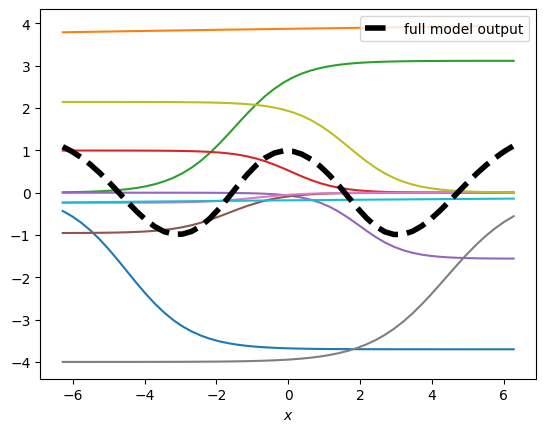

In [13]:
fig, ax = plt.subplots()
x = np.linspace(-2 * np.pi, 2 * np.pi)
x_tensor = torch.tensor(x, dtype=torch.float32)
F = torch.zeros_like(x_tensor)

# 하나의 축 위에 모든 그래프를 plot

W, B, V = model.model_parameters
for w, b, v in zip(W.flatten(), B.flatten(), V.flatten()):
    y = v.item() * torch.sigmoid(x_tensor * w.item() + b.item())
    ax.plot(x, y.detach().numpy())
    F += y

# v * sigmoid(x * w + b)를 모두 합한 것을 함께 plot
ax.plot(
    x,
    F.detach().numpy(),
    color="black",
    ls="--",
    lw=4,
    label="full model output",
)

ax.legend()
ax.set_xlabel(r"$x$")
plt.show()

### 배운 내용 되돌아보기

이번 실습에서는 Universal Approximation Theorem에 의거하여 함수 의 근사함수 의 모델을 로 세우고 학습을 진행하였다. 우리가 학습시킨 모델은 입력층과 출력층의 뉴런 수가 모두 1인 매우 간단한 형태의 신경망 모델이었지만, 앞으로 작성할 다양한 형태의 신경망의 기본이 되는 중요한 개념들이 많이 나왔다.

- batch의 개념을 적용하여 밀집층의 순전파를 직접 프로그래밍하였다. 근사함수 수식을 코딩으로 구현한 결과는 딱 한 줄이었지만, 그 한 줄이 잘 성립하는 코드인지를 확인하기 위해 배열의 연산을 하나씩 따라가며 자세히 살펴보았다.

- 이렇게 작성한 순전파 코드를 바탕으로 모델(클래스)를 정의하였다. 하이퍼파라미터인 은닉층의 뉴런 개수는 사용자가 입력하도록 하였고, 모델 파라미터는 표준정규분포를 따르도록 초기화하였다.

- 손실함수를 잔차 절댓값의 평균으로 정의하였다. batch에 대해 평균적인 손실을 구하여 학습에 사용함으로써 batch의 이점을 한 번 더 확인하였다.

- 경사하강법 함수는 실습 3과 실습 4에서 작성했던 함수와 동일하게 다시 작성하며 복습하였다.

- 근사하고자 하는 목표 함수가 로 명확히 주어졌기 때문에,  데이터 (train_data) 만 정해주면 함수를 이용하여 데이터셋의  데이터 (truth)를 쉽게 얻을 수 있었다. 이때,  데이터들에 대한 편미분 계수가 계산되지 않도록 를 상수 취급해야 했다.

- 학습을 진행할 때는 랜덤 batch를 구성하여 각 batch에 대해 iteration을 진행해야 했다. 이때, 랜덤 batch는 랜덤하게 섞인 인덱스 배열을 이용하여 train_data 배열에 랜덤하게 접근하는 방식으로 사용하였다.

- 1 iteration 동안 실제(truth)값과 모델의 순전파로 얻은 예측(prediction)값을 손실함수에 대입한 후, 손실함수에 대해 자동미분을 이용한 경사하강법을 진행하여 모델 파라미터를 1회 업데이트하였다. 모든 batch에 대해 iteration을 진행하는 epoch를 총 1000회 진행함으로써 모델을 효과적으로 학습시켰다.

- 학습 전과 후의 목표 함수 와 근사함수 를 비교해보았고, 학습이 진행됨에 따라 가 에 가까워지는 과정을 관찰해보기도 했다.


- 학습이 완료된 후, 은닉층의 각 뉴런들이 어떤 결과를 도출하는지 확인해보았다. 또한, 각 뉴런에서 도출한 결과에 가중치 연산을 한 결과와 그렇게 구한 모든 함수를 합한 결과를 함께 시각화함으로써 뉴런 단위로 학습 결과가 어떻게 나타났는지 살펴보았다.